# Facial Expression Recognition

This notebook can be used to train face recognition model in google colab using gpu backend. 

## Check Resources


#### 1.Install required packages

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize


  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /content/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /content/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize


####2.Check available GPU and CPU

In [2]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  I Proc size: 146.6 MB
GPU RAM Free: 11439MB | Used: 0MB | Util   0% | Total 11439MB


## Getting data from google drive


We can store our data in google drive and use it in our colab notebook

#### 1. Authenticate

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#### 2.Functions to load data from google drive

In [0]:
def get_file_from_drive(folder_id, file_name):
  file_list = drive.ListFile({'q': "'" + folder_id + "' in parents and trashed=false"}).GetList()
  for file in file_list:
    if file['title'] == file_name:
      return file['id']

def upload_file_to_drive(file_name, file_data):
  uploaded = drive.CreateFile({'title': file_name})
  uploaded.SetContentString(file_data)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))



## Data processing

#### 1.Loading required data from drive

In [5]:
#The folder id is the last part of the link of a folder
#Eg: https://drive.google.com/drive/folders/1K01twCLvCo40aOc6bBW4TlJZEzvPHSv3
#1K01twCLvCo40aOc6bBW4TlJZEzvPHSv3 is a folder id
try:
  data_drive_folder_id = '1JTnfzaSEEopJIGJ8Dgj_fXpOdSjVqUSH'
  train_file = 'Train.csv' 
  test_file = 'Test_data.csv'
  def upload_data_system():
    downloaded = drive.CreateFile({'id': get_file_from_drive(data_drive_folder_id, train_file)})
    downloaded.GetContentFile(train_file) 
    
    downloaded = drive.CreateFile({'id': get_file_from_drive(data_drive_folder_id, test_file)})
    downloaded.GetContentFile(test_file) 

  upload_data_system()
  print("Data uploaded")
except Exception as error:
  print("Can not upload given data.")
  print(error)

Data uploaded


#### 2.Preparing training,development and test set

In [6]:
import numpy as np
from keras.utils import np_utils
import pandas as pd

def process(data):
  #Seperating images data from labels ie emotion
  images = data.iloc[:,1:].values
  images = images.astype(np.float)

  #Normalizaton : convert from [0:255] => [0.0:1.0]
  images = np.multiply(images, 1.0 / 255.0)
  
  #Reshape pixels to 48*48 image
  images = np.reshape(images, [-1,48,48,1])
  
  print(images.shape)
  
  #Get labels from data
  labels = data[['label']].values.ravel()
  labels_count = np.unique(labels).shape[0]
  
  #Convert labels to one hot vectors
  labels = np_utils.to_categorical(labels,labels_count)
  
  return images,labels
  
#Read data
train = pd.read_csv('Train.csv')



Using TensorFlow backend.


Text(0.5,1,'Distribution of emotions,(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)')

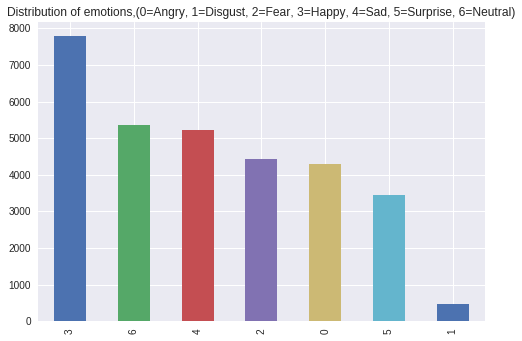

In [7]:
#Displaying total counts of different labels
import matplotlib.pyplot as plt
train.label.value_counts().plot(kind='bar')
plt.title("Distribution of emotions,(0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprised, 6=Neutral)")

There are very few samples of 'Disgust' so we will mearge it with 'Angry' 

Text(0.5,1,'Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprise, 5=Neutral)')

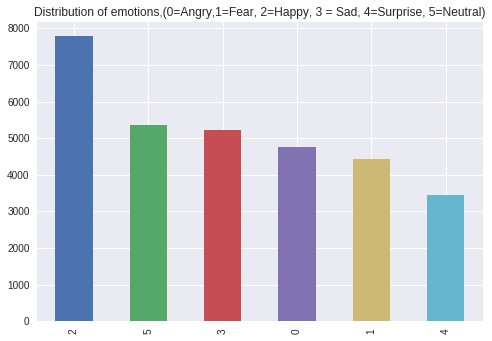

In [8]:
train['label'] = train['label'].map( {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5} ).astype(int)
train.label.value_counts().plot(kind='bar')
plt.title("Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprised, 5=Neutral)")


#### Balancing classes

Text(0.5,1,'Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprise, 5=Neutral)')

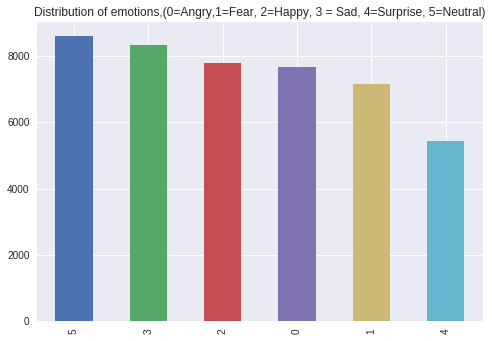

In [9]:
"Making copies of images to balance the class which prevents overfitting"
from sklearn.utils import shuffle

#As there are higher number of 'Happy' images, making copies of other images
df_copy = train[train.label != 2]
df_copy = df_copy[:int(0.6*len(df_copy.index))]
len(df_copy.index)
train_balanced = shuffle(pd.concat([train,df_copy]))

train_balanced.label.value_counts().plot(kind='bar')
plt.title("Distribution of emotions,(0=Angry,1=Fear, 2=Happy, 3 = Sad, 4=Surprise, 5=Neutral)")


In [0]:
#Preparing test data
test = pd.read_csv('Test_data.csv')
test['label'] = test['label'].map( {0:0, 1:0, 2:1, 3:2, 4:3, 5:4, 6:5} ).astype(int)


#### Process data

In [11]:
#Process data
train_x,train_y = process(train_balanced)
test_x,test_y =  process(test)

(44930, 48, 48, 1)
(4886, 48, 48, 1)


## VGG architecture for classification

In [0]:
from keras.models import Sequential
from keras.optimizers import SGD,Adadelta
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D,AveragePooling2D
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import PReLU
import keras

def VGG():
    img_rows, img_cols = 48, 48
    model = Sequential()
    model.add(Convolution2D(64, 5, 5, border_mode='valid',
                            input_shape=(img_rows, img_cols, 1)))
    model.add(PReLU(init='zero', weights=None))
    model.add(ZeroPadding2D(padding=(2, 2), dim_ordering='tf'))
    model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(64, 3, 3))
    model.add(PReLU(init='zero', weights=None))
    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(64, 3, 3))
    model.add(PReLU(init='zero', weights=None))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(128, 3, 3))
    model.add(PReLU(init='zero', weights=None))
    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(Convolution2D(128, 3, 3))
    model.add(PReLU(init='zero', weights=None))

    model.add(ZeroPadding2D(padding=(1, 1), dim_ordering='tf'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(PReLU(init='zero', weights=None))
    model.add(Dropout(0.2))

    model.add(Dense(6))

    model.add(Activation('softmax'))

    ada = Adadelta(lr=0.1, rho=0.95, epsilon=1e-08)
    model.compile(loss='categorical_crossentropy',
                  optimizer=ada,
                  metrics=['accuracy'])
    
    return model




### Load model

In [15]:
model = VGG()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(48, 48, 1..., padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, alpha_initializer="zero")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(padding=(2, 2), data_format="channels_last")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: UserWarning: Update your `ZeroPadding2D` call to the Keras 2 API: `ZeroPadding2D(padding=(1, 1), data_format="channels_last")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: UserWarning: Update your `PReLU` call to the K

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 44, 44, 64)        123904    
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 22, 22, 64)        30976     
__________

In [0]:
#Note: Reduce batch size if resources like GPU and RAM are low
batch_size = 100
epochs = 40

In [20]:
"""
Setuup for calling Callbacks in Notebook
Checkponts are stored in My Drive /Colab Notebooks
"""
!wget https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
import utils
import keras
import os
def compare(best, new):
  return best.losses['val_acc'] < new.losses['val_acc']

def path(new):
  if new.losses['val_acc'] > 0.2:
    return 'emotion_best_weights.h5'

callbacks_vgg = cb = [utils.GDriveCheckpointer(compare,path),
      keras.callbacks.TensorBoard(log_dir=os.path.join(utils.LOG_DIR,'emotion'))]

--2018-06-03 04:29:25--  https://raw.githubusercontent.com/Zahlii/colab-tf-utils/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6935 (6.8K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   6.77K  --.-KB/s    in 0s      

2018-06-03 04:29:25 (90.7 MB/s) - ‘utils.py’ saved [6935/6935]

    100% |████████████████████████████████| 51kB 2.1MB/s 
rm: cannot remove 'tboard.py': No such file or directory
--2018-06-03 04:29:32--  https://raw.githubusercontent.com/mixuala/colab_utils/master/tboard.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP

In [25]:
#Check if checkpoint is present in Colab Notebooks folder
#Upload checkpoint from drive to workspace
##The folder id is the last part of the link of a folder

ckpt_name = 'emotion_best_weights.h5'
checkpoint_folder_id = '1ayo2Cvfk20QgTwn53sWn3QwY-ADGx0LV'

try:
  def upload_data_system():
    downloaded = drive.CreateFile({'id': get_file_from_drive(checkpoint_folder_id,ckpt_name)})
    downloaded.GetContentFile(ckpt_name) 

  upload_data_system()
  
  model.load_weights(ckpt_name)
  print("Previous weights used")
except :
  print("No checkpoints")

Previous weights used


In [0]:
"""Dividing train data to train and validating set.
   Note: Use only while training using data augmentation"""
val_count = 3000 #Validation image number for data augmentation
val_x = train_x[:val_count]
val_y = train_y[:val_count]
train_x = train_x[val_count:]
train_y = train_y[val_count:]

In [24]:
"Training with augmented data. Augmentation takes place while training"

from keras.preprocessing.image import ImageDataGenerator

#Generate augmented data
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

valgen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False) 

datagen.fit(train_x)
valgen.fit(val_x)

model.fit_generator(datagen.flow(train_x, train_y,
                    batch_size=batch_size),
                    steps_per_epoch=len(train_x) /batch_size,
                    epochs=epochs,
                    validation_data = valgen.flow(val_x, val_y,
                    batch_size=batch_size),
                    callbacks=callbacks_vgg,verbose = 1)

#Note: Given training is done using best checkpoint saved after 200 epochs


Epoch 1/40
420/419 [==============================] - 42s 100ms/step - loss: 0.9238 - acc: 0.6496 - val_loss: 0.8733 - val_acc: 0.6800


Uploading file emotion_best_augmented.h5 to folder Colab Notebooks: 100%|██████████| 100/100 [00:01<00:00, 68.36it/s]

Epoch 2/40
  1/419 [..............................] - ETA: 42s - loss: 0.8140 - acc: 0.7300

420/419 [==============================] - 40s 96ms/step - loss: 0.9172 - acc: 0.6507 - val_loss: 0.9017 - val_acc: 0.6643
No improvement.
Epoch 3/40
290/419 [===================>..........] - ETA: 11s - loss: 0.9078 - acc: 0.6539420/419 [==============================] - 40s 96ms/step - loss: 0.9153 - acc: 0.6503 - val_loss: 0.8673 - val_acc: 0.6703
No improvement.
Epoch 4/40
390/419 [==========================>...] - ETA: 2s - loss: 0.9127 - acc: 0.6533420/419 [==============================] - 40s 96ms/step - loss: 0.9126 - acc: 0.6535 - val_loss: 0.8827 - val_acc: 0.6667
No improvement.
Epoch 5/40
420/419 [==============================] - 40s 96ms/step - loss: 0.9079 - acc: 0.6569 - val_loss: 0.9097 - val_acc: 0.6617
No improvement.
Epoch 6/40
  2/419 [..............................] - ETA: 39s - loss: 0.9118 - acc: 0.6200420/419 [==============================] - 40s 96ms/step - loss: 0.9077 - acc: 0.6564 - val_loss: 0.9184 - val_acc: 0.6490
No improvement.
Epoch 7/40
289/419 [==

In [26]:
"Check model accuracy in test data"
score = model.evaluate(test_x, test_y, batch_size=100)
print(score)

#0.9564394826436209 is loss 
#0.6461318021566225 is acuracy

4886/4886 [==============================] - 2s 328us/step
[0.9564394826436209, 0.6461318021566225]


In [0]:
#Note: Load saved weights before saving the model
#Note: You may encounter problem downloading the model, 
#so it is better to download the weights from drive and create model offline

#Save model
model.save('emotion_vgg16.h5')

print("Model Saved")
#Download model
from google.colab import files
files.download('emotion_vgg16.h5')